In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns 

%matplotlib inline
plt.style.use("default")


In [2]:
class DummyDataset(Dataset):
    def __init__(self, fpath) -> None:
        super().__init__()
        try:
            data = pd.read_csv(fpath).drop("cluster", axis=1).values
        except KeyError:
            data = pd.read_csv(fpath).values
        self.data = torch.Tensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index) -> tuple:
        return self.data[index, 1:], self.data[index, 0]


$$
\sum_{j} w_j \sigma_j \le \sum_{j} w_j \cdot 1 = 1
$$

In [3]:
class MultiExpertModel(nn.Module):
    def __init__(self, input_dim, num_expert) -> None:
        super().__init__()
        self.gate_mgr = nn.Linear(in_features=input_dim, out_features=num_expert)
        self.experts = nn.Linear(in_features=input_dim, out_features=num_expert)

    def forward(self, x):
        w = F.softmax(self.gate_mgr(x), dim=1)
        expert_scores = F.sigmoid(self.experts(x))
        return torch.sum(w * expert_scores, dim=1), w

    def evaluate(self, dataloader, criterion):
        total_loss = 0.0
        total_sample = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(dataloader):
                p_batch, w = self(X_batch)
                total_loss += criterion(p_batch, y_batch).item() #+ sparsity_regularizer(w)).item()
                total_sample += X_batch.shape[0]
        return total_loss / total_sample
    
    def train(self, dl, sparse_lambda, epochs=51, lr=5e-3):
        criterion = nn.BCELoss(reduction="mean")
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            total_loss = 0.0
            total_batch = 0.0
            disable = epoch % 25 != 0
            with tqdm(dl, unit="batch", mininterval=0, disable=disable) as bar:
                bar.set_description(f"Epoch {epoch}")
                for X_batch, y_batch in bar:
                    optimizer.zero_grad()
                    p_batch, w = self(X_batch)
                    try:
                        loss = criterion(p_batch, y_batch) + sparse_lambda * sparsity_regularization(w)
                    except RuntimeError:
                        print(p_batch)
                        break
                    loss.backward()
                    optimizer.step()
                    # update progress bar
                    total_loss += loss.item()
                    total_batch += 1
                    bar.set_postfix(loss=float(total_loss / total_batch))

def sparsity_regularization(w):
    H = Categorical(probs=w).entropy()
    return H.mean()




In [4]:
def visualize_expert_decisions(model, lims, grid_n):
    xs = torch.linspace(start=lims[0], end=lims[1], steps=grid_n)
    ys = torch.linspace(start=lims[0], end=lims[1], steps=grid_n)
    ws = F.softmax(model.gate_mgr(torch.cartesian_prod(ys, xs)), dim=1).detach()

    fig, axs = plt.subplots(1, ws.shape[1], sharey=True)
    for i in range(ws.shape[1]):
        im = axs[i].imshow(
            ws[:,i].reshape(grid_n, grid_n).T,
            extent=[lims[0], lims[1], lims[1], lims[0]],
            vmin=0, vmax=1
        )
        axs[i].invert_yaxis()
        
    fig.tight_layout(pad=1)
    plt.title("Weight distribution across experts", loc='right')
    fig.colorbar(im, ax=axs, orientation='horizontal')
    plt.show()

    scores = F.sigmoid(model.experts(torch.cartesian_prod(ys, xs))).detach()
    fig, axs = plt.subplots(1, scores.shape[1], sharey=True)
    for i in range(scores.shape[1]):
        im = axs[i].imshow(
            scores[:,i].reshape(grid_n, grid_n).T,
            extent=[lims[0], lims[1], lims[1], lims[0]],
            vmin=0, vmax=1
        )
        axs[i].invert_yaxis()

    fig.tight_layout(pad=1)
    fig.colorbar(im, ax=axs.ravel(), orientation='horizontal')
    plt.title("Score distribution across experts", loc='right')
    plt.show()

    p = model(torch.cartesian_prod(ys, xs))[0].detach()
    fig, ax = plt.subplots()
    im = ax.imshow(
        p.reshape(grid_n, grid_n).T,
        extent=[lims[0], lims[1], lims[1], lims[0]],
        vmin=0, vmax=1
    )
    ax.invert_yaxis()
    fig.colorbar(im, ax=ax, orientation='horizontal')
    plt.title("Aggregated decision")
    plt.show()


In [ ]:
train = DummyDataset("./simulate_data/sphere_train.csv") # sigma = 0.2
test = DummyDataset("./simulate_data/sphere_test.csv")

train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)

train.data[:1000, 1].std()


In [5]:
dat = DummyDataset("../mnist_latent_tsne.csv")
dat.data[:, 0] = (dat.data[:, 0] == 5).to(torch.float32) # make binary
dat.data = dat.data[:, [0, -2, -1]]
dl = DataLoader(dat, 128, shuffle=False)


### without sparcity

In [58]:
model = MultiExpertModel(input_dim=2, num_expert=10)
model.train(dl=dl, sparse_lambda=0)


Epoch 50: 100%|██████████| 91/91 [00:00<00:00, 180.77batch/s, loss=0.266]


In [59]:
roc_auc_score(
    y_true=dl.dataset.data[:, 0],
    y_score=model(dl.dataset.data[:, 1:])[0].detach(),
)


0.9562675292936298

In [60]:
sparsity_regularization(
	F.softmax(model.gate_mgr(dl.dataset.data[:, 1:]), dim=1)
) / len(dl.dataset)


tensor(4.0731e-05, grad_fn=<DivBackward0>)

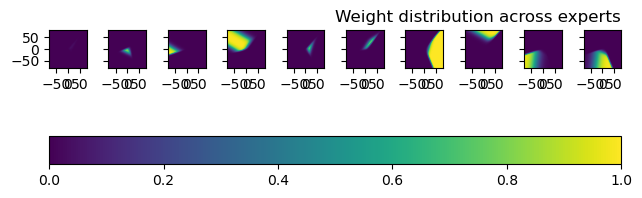

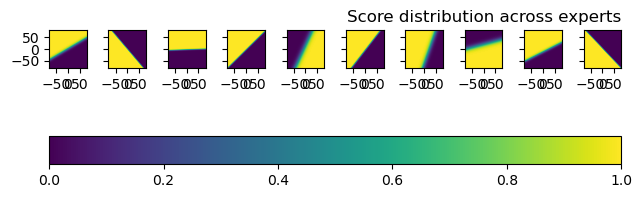

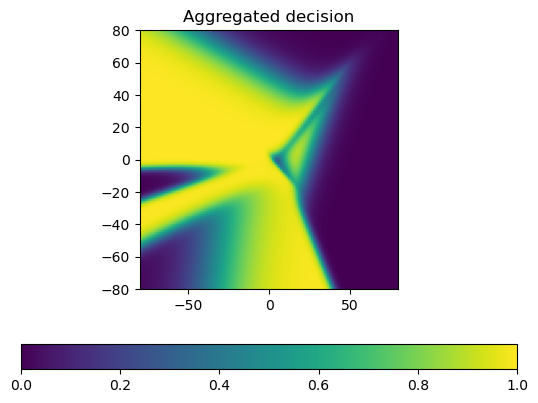

In [61]:
c = 80
visualize_expert_decisions(model, (-c, c), 100)


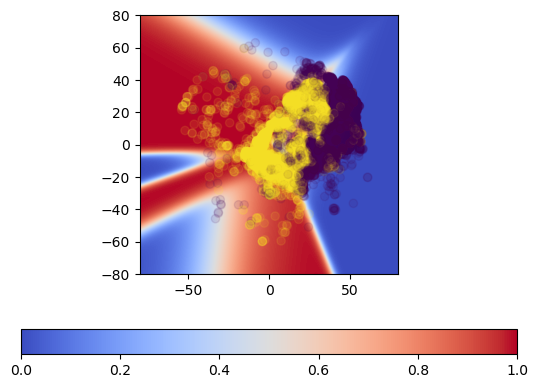

In [62]:
xs = torch.linspace(start=-c, end=c, steps=1000)
ys = torch.linspace(start=-c, end=c, steps=1000)
p = model(torch.cartesian_prod(xs, ys))[0].detach()
fig, ax = plt.subplots()
im = ax.imshow(
	p.reshape(1000, 1000).T,
	extent=[-c, c, c, -c],
	vmin=0, vmax=1, cmap=cm.coolwarm
)
ax.invert_yaxis()
fig.colorbar(im, ax=ax, orientation='horizontal')
idx = model(dl.dataset.data[:, 1:])[0].detach() > 0.5
plt.scatter(
	x=dat.data[:, 1],
	y=dat.data[:, 2],
	c=dat.data[:, 0],
	alpha=0.1
)
plt.show()


### with sparcity

In [10]:
sparse_model = MultiExpertModel(input_dim=2, num_expert=10)
sparse_model.train(dl=dl, sparse_lambda=20, epochs=101)


Epoch 100: 100%|██████████| 91/91 [00:00<00:00, 135.26batch/s, loss=0.406]


In [73]:
for name, param in sparse_model.named_parameters():
	print(name, param)


gate_mgr.weight Parameter containing:
tensor([[-0.4462,  0.1895],
        [-0.5333,  0.3741],
        [ 0.4279,  0.3468],
        [ 0.2804, -0.1115],
        [ 0.5137,  0.2465],
        [-0.4351,  0.4088],
        [ 0.6098, -0.5300],
        [-0.3411,  0.6201],
        [-0.6035, -0.2560],
        [ 0.5421, -0.1392]], requires_grad=True)
gate_mgr.bias Parameter containing:
tensor([ 0.3383, -0.4166, -0.4395, -0.3158,  0.6545,  0.1826,  0.2957,  0.4283,
        -0.2857, -0.1248], requires_grad=True)
experts.weight Parameter containing:
tensor([[-0.3846, -0.1576],
        [-0.2040, -0.6457],
        [ 0.2294,  0.3793],
        [-0.1312, -0.6269],
        [-0.0159,  0.5491],
        [-0.7258, -0.0103],
        [ 0.5853,  0.4778],
        [ 0.6386, -0.1147],
        [-0.5687,  0.2679],
        [ 0.0806, -0.5331]], requires_grad=True)
experts.bias Parameter containing:
tensor([ 0.5288,  0.3898, -0.2681,  0.5794,  0.4343,  0.0853,  0.5187, -0.0358,
         0.4214, -0.6822], requires_grad=True

In [11]:
roc_auc_score(
    y_true=dl.dataset.data[:, 0],
    y_score=sparse_model(dl.dataset.data[:, 1:])[0].detach(),
)


0.9412311913013032

In [12]:
sparsity_regularization(
	F.softmax(sparse_model.gate_mgr(dl.dataset.data[:, 1:]), dim=1)
) / len(dl.dataset)


tensor(3.8384e-07, grad_fn=<DivBackward0>)

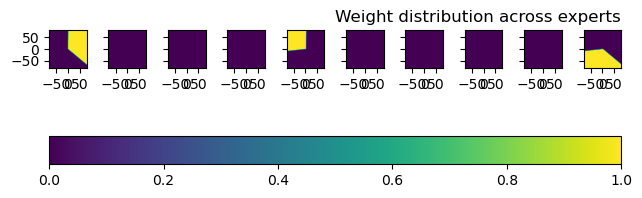

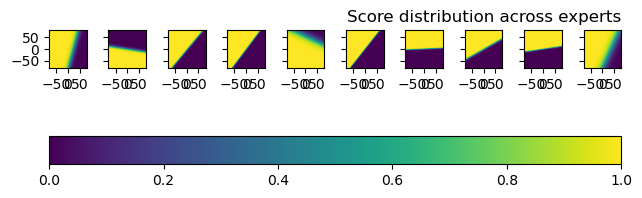

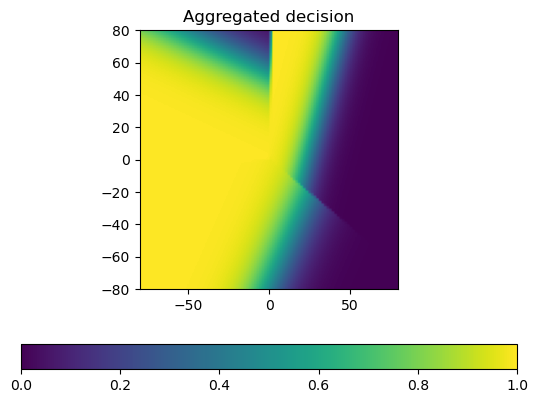

In [14]:
c = 80
visualize_expert_decisions(sparse_model, (-c, c), 100)


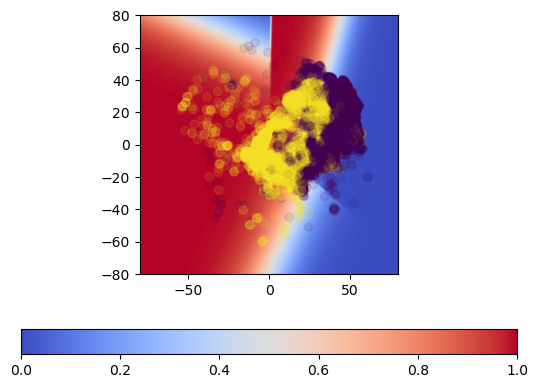

In [15]:
xs = torch.linspace(start=-c, end=c, steps=1000)
ys = torch.linspace(start=-c, end=c, steps=1000)
p = sparse_model(torch.cartesian_prod(xs, ys))[0].detach()
fig, ax = plt.subplots()
im = ax.imshow(
	p.reshape(1000, 1000).T,
	extent=[-c, c, c, -c],
	vmin=0, vmax=1, cmap=cm.coolwarm
)
ax.invert_yaxis()
fig.colorbar(im, ax=ax, orientation='horizontal')
idx = sparse_model(dl.dataset.data[:, 1:])[0].detach() > 0.5
plt.scatter(
	x=dat.data[:, 1],
	y=dat.data[:, 2],
	c=dat.data[:, 0],
	alpha=0.1
)
plt.show()


# plots in scratch

In [17]:
plot_data = pd.DataFrame(
    {
        "phat": model(test_dl.dataset.data[:, 1:]).detach().numpy(),
        "y": test_dl.dataset.data[:, 0].numpy().astype("int").astype("str"),
		"cluster": pd.read_csv("./test.csv")["cluster"].values.astype("str")
    }
)
plot_data


,phat,y,cluster
0,0.025322,0,1
1,0.057804,0,1
2,0.005646,0,1
3,0.149999,0,1
4,0.003599,0,1
...,...,...,...
1595,0.112530,0,4
1596,0.112917,0,4
1597,0.114462,0,4
1598,0.283605,0,4


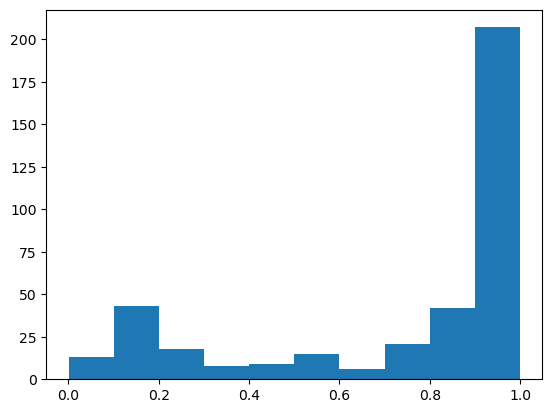

In [23]:
plt.hist(x=plot_data.loc[plot_data['y'] == "1"]["phat"].values)
plt.show()


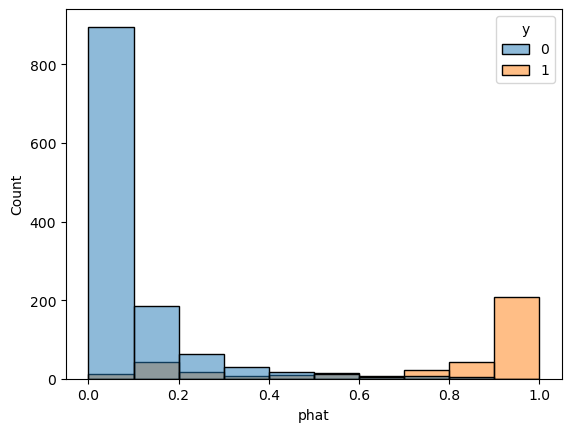

In [20]:
fig = sns.histplot(data=plot_data, x="phat", hue="y", binwidth=0.1, stat="count", palette=sns.color_palette("tab10", 2))
# fig.set_yscale("log")
plt.show()


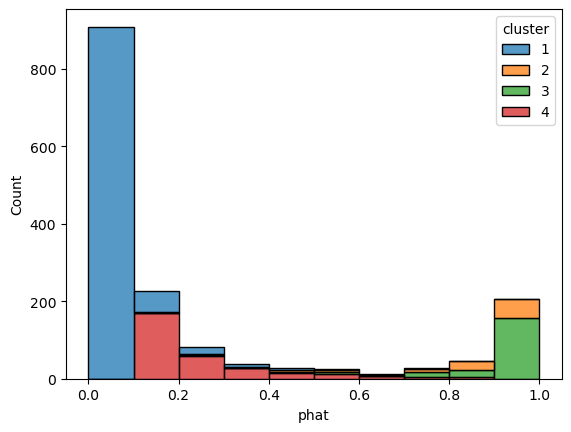

In [22]:
sns.histplot(data=plot_data, x="phat", hue="cluster", binwidth=0.1, stat="count", multiple="stack", palette=sns.color_palette("tab10", 4))
plt.show()
